In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: pip.repos.neuron.amazonaws.com, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import numpy as np
import pandas as pd
import torch
import transformers
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
import sys
from scipy.sparse import load_npz
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv

ImportError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
folder = '/content/drive/MyDrive/CSC311/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Trianing data and preprocess

In [ ]:
def _load_csv(path):
    # A helper function to load the csv file.
    if not os.path.exists(path):
        raise Exception("The specified path {} does not exist.".format(path))
    # Initialize the data.
    data = {
        "user_id": [],
        "question_id": [],
        "is_correct": []
    }
    # Iterate over the row to fill in the data.
    with open(path, "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            try:
                data["question_id"].append(int(row[0]))
                data["user_id"].append(int(row[1]))
                data["is_correct"].append(int(row[2]))
            except ValueError:
                # Pass first row.
                pass
            except IndexError:
                # is_correct might not be available.
                pass
    return data

def load_train_csv(root_dir=folder+"/data"):
    """ Load the training data as a dictionary.

    :param root_dir: str
    :return: A dictionary {user_id: list, question_id: list, is_correct: list}
        WHERE
        user_id: a list of user id.
        question_id: a list of question id.
        is_correct: a list of binary value indicating the correctness of
        (user_id, question_id) pair.
    """
    path = os.path.join(root_dir, "train_data.csv")
    return _load_csv(path)


def load_valid_csv(root_dir=folder+"/data"):
    """ Load the validation data as a dictionary.

    :param root_dir: str
    :return: A dictionary {user_id: list, question_id: list, is_correct: list}
        WHERE
        user_id: a list of user id.
        question_id: a list of question id.
        is_correct: a list of binary value indicating the correctness of
        (user_id, question_id) pair.
    """
    path = os.path.join(root_dir, "valid_data.csv")
    return _load_csv(path)

def load_train_sparse(root_dir=folder+"/data"):
    """ Load the training data as a spare matrix representation.

    :param root_dir: str
    :return: 2D sparse matrix
    """
    path = os.path.join(root_dir, "train_sparse.npz")
    if not os.path.exists(path):
        raise Exception("The specified path {} "
                        "does not exist.".format(os.path.abspath(path)))
    matrix = load_npz(path)
    return matrix

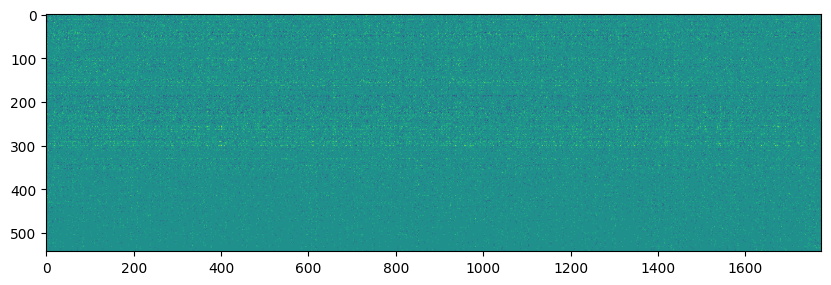

In [ ]:
TRAIN_MAT = load_train_sparse().toarray()
TRAIN_MAT = np.nan_to_num(TRAIN_MAT, nan=-2)
TRAIN_MAT[TRAIN_MAT == 0] = -1
TRAIN_MAT[TRAIN_MAT == -2] = 0

plt.figure(figsize=(10, 6))
plt.imshow(TRAIN_MAT)
plt.show()

In [ ]:
def preprocess(matrix):
    row_pos = {}
    row_neg = {}
    col_pos = {}
    col_neg = {}

    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value == 1:
                if j not in row_pos:
                    row_pos[j] = []
                row_pos[j].append(i)
                
                if i not in col_pos:
                    col_pos[i] = []
                col_pos[i].append(j)

            elif value == -1:
                if j not in row_neg:
                    row_neg[j] = []
                row_neg[j].append(i)
                
                if i not in col_neg:
                    col_neg[i] = []
                col_neg[i].append(j)

    return (row_pos, row_neg, col_pos, col_neg)

def get_all_relatives(coord, preprocessed_data_dict):
    row_pos, row_neg, col_pos, col_neg = preprocessed_data_dict
    i, j = coord
    if TRAIN_MAT[i, j] == 0:
      return None
    return (
        (row_pos.get(j, [])),
        (row_neg.get(j, [])),
        (col_pos.get(i, [])),
        (col_neg.get(i, [])),
    )


def get_all_relatives_numpy(coords, preprocessed_data, MAT=TRAIN_MAT):
    row_pos, row_neg, col_pos, col_neg = preprocessed_data

    row_pos_np = np.array([np.array(row_pos.get(j, []), dtype=int) for j in range(MAT.shape[1])], dtype=object)
    row_neg_np = np.array([np.array(row_neg.get(j, []), dtype=int) for j in range(MAT.shape[1])], dtype=object)
    col_pos_np = np.array([np.array(col_pos.get(i, []), dtype=int) for i in range(MAT.shape[0])], dtype=object)
    col_neg_np = np.array([np.array(col_neg.get(i, []), dtype=int) for i in range(MAT.shape[0])], dtype=object)

    i, j = coords.T
    mask = MAT[i, j] != 0
    valid_i, valid_j = i[mask], j[mask]

    results = (
        row_pos_np[valid_j],
        row_neg_np[valid_j],
        col_pos_np[valid_i],
        col_neg_np[valid_i],
    )

    return results


# Example usage

preprocessed_data_dict = preprocess(TRAIN_MAT)

In [ ]:
print(get_all_relatives((1, 1), preprocessed_data_dict))
print([get_all_relatives_numpy(np.array([[1, 1], [2, 2]]), preprocessed_data_dict)[i][0].shape for i in range(4)])

([5, 63, 135, 190, 193, 211, 254, 262, 276, 281, 308, 312, 356, 483], [1, 46, 50, 102, 105, 264, 343, 349, 359, 391, 443, 451], [63, 101, 169, 195, 273, 311, 362, 377, 412, 469, 591, 601, 721, 724, 842, 909, 950, 979, 1021, 1088, 1128, 1190, 1209, 1359, 1361, 1378, 1415, 1432, 1540, 1575, 1629, 1634, 1715, 1757], [1, 35, 83, 189, 272, 400, 518, 620, 793, 846, 967, 1303, 1385, 1400, 1501, 1559, 1588, 1645])
[(14,), (12,), (34,), (18,)]


In [ ]:
a = np.arange(0, 542)
b = np.arange(0, 1774)
grid = np.meshgrid(a, b)
matrix = np.column_stack((grid[0].flatten(), grid[1].flatten()))

output = get_all_relatives_numpy(matrix, preprocessed_data_dict)

In [ ]:
row_pos, row_neg, col_pos, col_neg = output

In [ ]:
rpm, rnm, cpm, cnm = [], [], [], []

# Iterate through each sublist in the nested list
for i in range(row_pos.shape[0]):
    # Append the length of the current sublist to the length_list
    rpm.append(len(row_pos[i]))
    rnm.append(len(row_neg[i]))
    cpm.append(len(col_pos[i]))
    cnm.append(len(col_neg[i]))

print(max(rpm), max(rnm), max(cpm), max(cnm))

50 35 421 331


# **Model**

In [ ]:
import torch
import torch.nn as nn
from torch.nn import MultiheadAttention

class Transformer(nn.Module):
    def __init__(self, num_layers, d_model=128, nhead=8, dropout=0.1):
        super(Transformer, self).__init__()

        self.student_embed = nn.Linear(1774, d_model)
        self.question_embed = nn.Linear(768, d_model)

        # Create a stack of MultiheadAttention layers
        self.student_multihead_attn_layers = nn.ModuleList([MultiheadAttention(d_model, nhead, dropout=dropout) for _ in range(num_layers)])
        self.question_multihead_attn_layers = nn.ModuleList([MultiheadAttention(d_model, nhead, dropout=dropout) for _ in range(num_layers)])

        self.ff = nn.Sequential(nn.Linear(4 * d_model, 64), nn.ReLU(), nn.Linear(64, 2), nn.Softmax(dim=1))

    def forward(self, student_pos, student_neg, question_pos, question_neg, question, student):
        student_pos_embed = self.student_embed(student_pos)
        student_neg_embed = self.student_embed(student_neg) * -1
        question_pos_embed = self.question_embed(question_pos)
        question_neg_embed = self.question_embed(question_neg) * -1

        question_embed = self.question_embed(question)
        student_embed = self.student_embed(student)

        # print(question_pos_embed.size())
        # print(question_neg_embed.size())
        # print("FUCK!!!")

        question_key_value = torch.cat((question_pos_embed, question_neg_embed), dim=1)
        student_key_value = torch.cat((student_pos_embed, student_neg_embed), dim=1)

        # Compute the attention using the question as the query and the other embeddings as key and value
        question_context_vector = question_embed.unsqueeze(1)
        student_context_vector = question_embed.unsqueeze(1)
        
        question_context_vector = question_context_vector.transpose(0, 1)
        question_key_value = question_key_value.transpose(0, 1)

        for attn_layer in self.question_multihead_attn_layers:
            question_context_vector, _ = attn_layer(query=question_context_vector, 
                                                    key=question_key_value,
                                                    value=question_key_value)
            
            # question_context_vector, _ = attn_layer(query=question_context_vector, 
            #                                         key=question_key_value.unsqueeze(1),
            #                                         value=question_key_value.unsqueeze(1))

        student_context_vector = student_context_vector.transpose(0, 1)
        student_key_value = student_key_value.transpose(0, 1)

        
        for attn_layer in self.student_multihead_attn_layers:   
            student_context_vector, _ = attn_layer(query=student_context_vector, 
                                                    key=student_key_value,
                                                    value=student_key_value)

        # print("FUCK!!!!")
        # print(question_context_vector.size())

        question_context_vector = question_context_vector.squeeze(0)
        student_context_vector = student_context_vector.squeeze(0)

        # print(question_context_vector.size())
        # print(question_embed.size())

        combined_vector = torch.cat((question_context_vector, question_embed, student_context_vector, student_embed), dim=1)
        
        output = self.ff(combined_vector)

        return output


# Train & test

In [ ]:
def tensor_from_arr(arrays, map, device):
    # Create a list of tensors from the nested numpy arrays
    tensor_list = [torch.tensor(map[subarray], dtype=torch.float32, device=device) for subarray in arrays]

    len = map[0].shape[0]

    # Get the lengths of the subarrays
    lengths = [(subarray.shape[0]) for subarray in arrays]

    # print([(subarray.shape) for subarray in arrays])

    # Calculate the maximum length
    max_length = max(lengths)

    # Pad the tensors and create a list of padded tensors
    padded_tensor_list = [torch.cat([tensor, torch.zeros((max_length - (tensor.shape[0]), len), device=device)]) for tensor in tensor_list]

    # Stack the padded tensors to create a tensor of shape (batchsize, max_length)
    result = torch.stack(padded_tensor_list)
    lengths = torch.tensor(lengths).to(device)

    return result, lengths

In [ ]:
def train_epoch(model, QUESTION_EMBED, TRAIN_MAT, preprocessed_data_dict, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch in tqdm(data_loader, desc="Training"):
        student_ids = batch['user_id'].numpy().astype('int32')
        question_ids = batch['question_id'].numpy().astype('int32')
        labels = batch['is_correct'].long().to(device)


        coords = np.concatenate([student_ids.reshape(student_ids.shape[0], 1),
                                question_ids.reshape(question_ids.shape[0], 1)],
                                axis=1)

        rslt = get_all_relatives_numpy(coords, preprocessed_data_dict)

        student_pos_ids, student_neg_ids, question_pos_ids, question_neg_ids = rslt

        student_pos, student_pos_len = tensor_from_arr(student_pos_ids, TRAIN_MAT, device)
        student_neg, student_neg_len = tensor_from_arr(student_neg_ids, TRAIN_MAT, device)
        question_pos, question_pos_len = tensor_from_arr(question_pos_ids, QUESTION_EMBED, device)
        question_neg, question_neg_len = tensor_from_arr(question_neg_ids, QUESTION_EMBED, device)

        student_embedding = torch.tensor(TRAIN_MAT[student_ids], dtype=torch.float32).to(device)
        question_embedding = batch['question_embedding'].to(device)

        optimizer.zero_grad()
        logits = model(student_pos=student_pos, 
                       student_neg=student_neg, 
                       question_pos=question_pos, 
                       question_neg=question_neg, 
                       question=question_embedding, 
                       student=student_embedding).squeeze()

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        torch.cuda.empty_cache() 

    return running_loss / len(data_loader)

In [ ]:
def evaluate_with_acc(model, QUESTION_EMBED, TRAIN_MAT, VAL_MAT, preprocessed_val_dict, data_loader, criterion, device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    FULL_MAT = np.clip(TRAIN_MAT + VAL_MAT, a_min=-1, a_max=1)
    
    with torch.no_grad():
        for batch in data_loader:
            student_ids = batch['user_id'].numpy().astype('int32')
            question_ids = batch['question_id'].numpy().astype('int32')
            labels = batch['is_correct'].long().to(device)


            coords = np.concatenate([student_ids.reshape(student_ids.shape[0], 1),
                                    question_ids.reshape(question_ids.shape[0], 1)],
                                    axis=1)

            rslt = get_all_relatives_numpy(coords, preprocessed_val_dict, MAT=FULL_MAT)

            # print(rslt)

            student_pos_ids, student_neg_ids, question_pos_ids, question_neg_ids = rslt

            student_pos, student_pos_len = tensor_from_arr(student_pos_ids, TRAIN_MAT, device)
            student_neg, student_neg_len = tensor_from_arr(student_neg_ids, TRAIN_MAT, device)
            question_pos, question_pos_len = tensor_from_arr(question_pos_ids, QUESTION_EMBED, device)
            question_neg, question_neg_len = tensor_from_arr(question_neg_ids, QUESTION_EMBED, device)

            student_embedding = torch.tensor(TRAIN_MAT[student_ids], dtype=torch.float32).to(device)
            question_embedding = batch['question_embedding'].to(device)

            logits =  model(student_pos=student_pos, 
                            student_neg=student_neg, 
                            question_pos=question_pos, 
                            question_neg=question_neg, 
                            question=question_embedding, 
                            student=student_embedding).squeeze()

            loss = criterion(logits, labels)
            running_loss += loss.item()
            
            predictions = (logits[:, 0] < threshold).long()
            correct_predictions += torch.sum(predictions == labels).item()
            total_predictions += labels.size(0)
    
    accuracy = correct_predictions / total_predictions
    return running_loss / len(data_loader), accuracy

# Data Loader

In [ ]:
class ModelDataset(Dataset):
    def __init__(self, data, question_embeddings):
        self.user_ids = data['user_id']
        self.question_ids = data['question_id']
        self.is_correct = data['is_correct']
        self.question_embeddings = question_embeddings

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return {
            'user_id': self.user_ids[idx],
            'question_id': self.question_ids[idx],
            'question_embedding': self.question_embeddings[self.question_ids[idx]],
            'is_correct': self.is_correct[idx],
        }

In [ ]:
train_data = load_train_csv()
val_data = load_valid_csv()

# print(data)
question_embeddings = np.load(folder+'/data/extracted_feats_question_comp.npy')
QUESTION_EMBEDDING = question_embeddings
train_ds = ModelDataset(train_data, question_embeddings)
train_dataloader = DataLoader(train_ds, batch_size=384, shuffle=True)

val_ds = ModelDataset(val_data, question_embeddings)
val_dataloader = DataLoader(val_ds, batch_size=384, shuffle=True)

In [ ]:
def dict2matrix(data):
    user_ids = data['user_id']
    question_ids = data['question_id']
    is_correct = data['is_correct']

    matrix = np.zeros((np.max(user_ids) + 1, np.max(question_ids) + 1))
    matrix[:] = np.nan
    matrix[user_ids, question_ids] = is_correct
    return matrix

val_mat = dict2matrix(val_data)
val_mat = np.nan_to_num(val_mat, nan=-2)
val_mat[val_mat == 0] = -1
val_mat[val_mat == -2] = 0

preprocessed_val_dict = preprocess(np.clip(TRAIN_MAT + val_mat, a_min=-1, a_max=1))

In [ ]:
print(np.clip(TRAIN_MAT + val_mat, a_min=-1, a_max=1))

[[-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [ ]:
print(preprocessed_val_dict)
print(preprocessed_data_dict)

({18: [0, 18, 19, 47, 49, 50, 51, 70, 79, 93, 95, 96, 105, 113, 129, 134, 144, 151, 163, 172, 180, 186, 190, 191, 207, 213, 223, 231, 233, 256, 263, 264, 275, 281, 290, 299, 300, 301, 310, 324, 341, 351, 354, 356, 373, 389, 411, 473], 19: [0, 6, 12, 19, 36, 47, 49, 66, 102, 129, 154, 163, 186, 189, 223, 226, 231, 257, 258, 274, 275, 284, 290, 291, 295, 300, 301, 305, 330, 332, 345, 373], 30: [0, 12, 36, 37, 48, 55, 61, 81, 88, 113, 114, 123, 144, 149, 152, 161, 163, 170, 172, 211, 221, 226, 231, 243, 246, 263, 280, 300, 301, 321, 415], 47: [0, 4, 48, 49, 101, 129, 144, 150, 192, 213, 221, 223, 240, 251, 255, 274, 280, 291, 310, 330, 428, 504], 62: [0, 12, 36, 46, 51, 61, 66, 120, 123, 144, 152, 153, 168, 212, 216, 251, 255, 257, 264, 266, 274, 291, 301, 311, 356, 376, 444], 68: [0, 6, 12, 18, 36, 40, 48, 51, 70, 83, 102, 103, 129, 139, 144, 152, 154, 161, 163, 172, 178, 180, 192, 212, 223, 257, 259, 262, 263, 275, 281, 291, 292, 305, 332, 410], 74: [0, 6, 12, 19, 36, 68, 75, 102, 129, 

In [ ]:
transformer = Transformer(num_layers=8, d_model=192, nhead=8, dropout=0.1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0003)
transformer.to(device)

train_loss = 0.0

# Train and evaluate the model
for epoch in range(num_epochs):
    train_loss = train_epoch(transformer, 
                             QUESTION_EMBEDDING, 
                             TRAIN_MAT,
                             preprocessed_data_dict, 
                             train_dataloader, 
                             criterion, 
                             optimizer, 
                             device)
    
    val_loss, acc = evaluate_with_acc(transformer, 
                                      QUESTION_EMBEDDING, 
                                      TRAIN_MAT, 
                                      val_mat,
                                      preprocessed_val_dict,
                                      val_dataloader,
                                      criterion,
                                      device)
    # val_loss = 0
    # acc = 0

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc:  {acc:.4f}')
    torch.cuda.empty_cache()

Training:   0%|          | 0/222 [00:00<?, ?it/s]